In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sushanthworks18","key":"cd4728ed897b9b062082e98c9580470e"}'}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kaggle

In [33]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [34]:
# !kaggle competitions download <name-of-competition>
!kaggle datasets download adityajn105/flickr8k

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [35]:
!unzip /content/flickr8k.zip

unzip:  cannot find or open /content/flickr8k.zip, /content/flickr8k.zip.zip or /content/flickr8k.zip.ZIP.


In [36]:
!rm -rf /content/flickr8k.zip /content/sample_data

In [37]:
!pip install torch-geometric rouge-score

In [38]:
import os
import re
import time
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch_geometric.nn as gnn
from torch_geometric.data import Data, Batch
import networkx as nx
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import torchvision
from nltk.translate.bleu_score import corpus_bleu
import warnings
warnings.filterwarnings("ignore")
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [39]:
DATASET_PATH = '/content'
IMAGES_PATH = os.path.join(DATASET_PATH, 'Images')
CAPTIONS_FILE = os.path.join(DATASET_PATH, 'captions.txt')

In [40]:
def load_captions(captions_file):
    captions_df = pd.read_csv(captions_file)
    # If the file doesn't have headers, use this instead:
    # captions_df = pd.read_csv(captions_file, header=None, names=['image', 'caption'])

    print(f"Number of captions: {len(captions_df)}")
    print(f"Sample captions:\n{captions_df.head()}")
    return captions_df

captions_df = load_captions(CAPTIONS_FILE)

Number of captions: 40455
Sample captions:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [41]:
captions_df.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [42]:
captions_df.shape

(40455, 2)

In [43]:
captions_df = captions_df.head(8000)
# captions_df.shape

In [44]:
def group_captions_by_image(captions_df):
    captions_dict = {}
    for _, row in captions_df.iterrows():
        image_name = row['image']
        caption = row['caption']

        if image_name not in captions_dict:
            captions_dict[image_name] = []
        captions_dict[image_name].append(caption)

    return captions_dict

image_captions = group_captions_by_image(captions_df)
print(f"Number of images: {len(image_captions)}")

Number of images: 1600


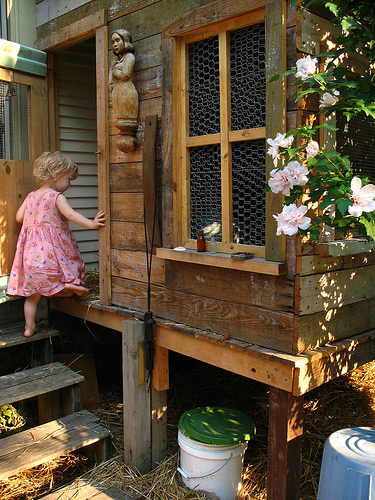

In [45]:
sample_image = list(image_captions.keys())[0]
Image.open(os.path.join(IMAGES_PATH,sample_image))

In [46]:
for i, caption in enumerate(image_captions[sample_image]):
    print(f"Caption {i+1}: {caption}")

Caption 1: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption 2: A girl going into a wooden building .
Caption 3: A little girl climbing into a wooden playhouse .
Caption 4: A little girl climbing the stairs to her playhouse .
Caption 5: A little girl in a pink dress going into a wooden cabin .


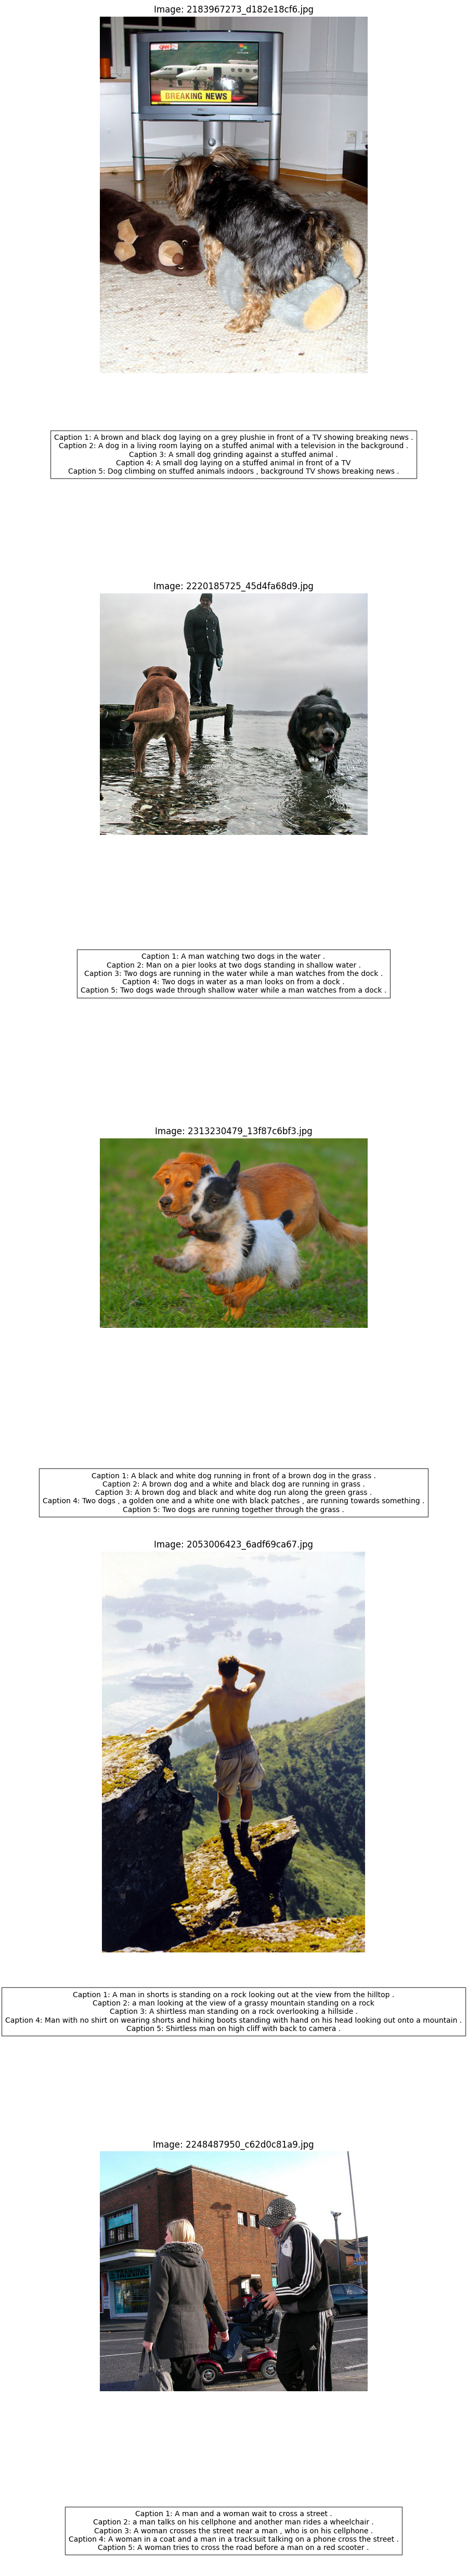

In [47]:
def visualize_samples(images_path, image_captions, num_samples=5):
    image_names = list(image_captions.keys())
    np.random.shuffle(image_names)

    fig, axes = plt.subplots(nrows=min(num_samples, len(image_names)) * 2, ncols=1,
                             figsize=(8, 10 * num_samples), gridspec_kw={'height_ratios': [4, 0.8] * num_samples})

    for i in range(min(num_samples, len(image_names))):
        image_name = image_names[i]
        image_path = os.path.join(images_path, image_name)

        try:
            image = Image.open(image_path)

            # Image display
            axes[2 * i].imshow(image)
            axes[2 * i].set_title(f"Image: {image_name}", fontsize=12)
            axes[2 * i].axis('off')

            # Caption display
            captions = image_captions[image_name]
            caption_text = "\n".join([f"Caption {j+1}: {caption}" for j, caption in enumerate(captions)])
            axes[2 * i + 1].text(0.5, 0.5, caption_text, ha='center', va='center', fontsize=10,
                                 bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 5})
            axes[2 * i + 1].axis('off')

        except Exception as e:
            print(f"Error displaying image {image_name}: {str(e)}")

    plt.tight_layout(pad=1.0)  # Reduced padding
    plt.show()

visualize_samples(IMAGES_PATH, image_captions)

Total number of captions: 8000
Total words across all captions: 95026
Vocabulary size: 4117

Most common words:
a: 12720
.: 7236
in: 3717
the: 3696
on: 2193
is: 1919
dog: 1854
and: 1774
with: 1589
man: 1467
of: 1299
two: 1062
boy: 907
black: 822
girl: 746
white: 730
to: 691
woman: 644
water: 639
wearing: 626

Caption length statistics:
Average caption length: 11.88 words
Maximum caption length: 35 words
Minimum caption length: 2 words


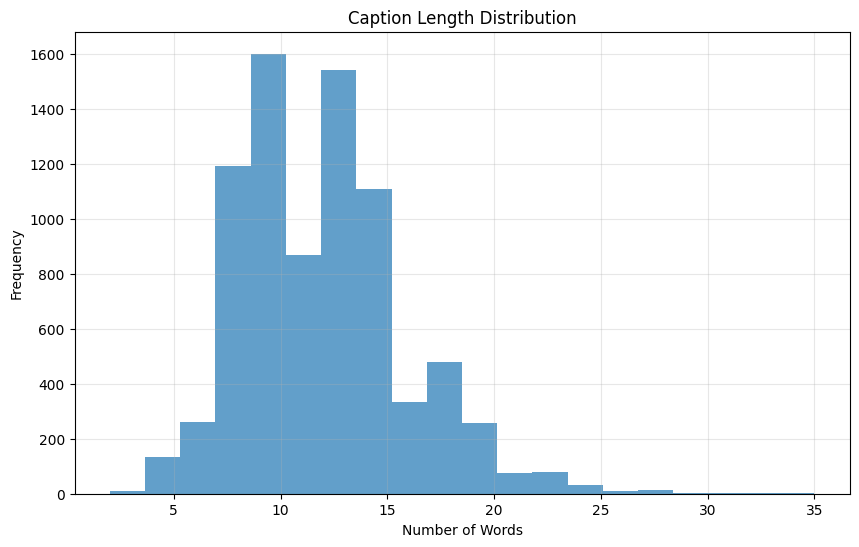

In [48]:
# Cell 7: Analyze caption text
def analyze_captions(captions_df):
    # Extract all captions
    all_captions = captions_df['caption'].tolist()

    # Tokenize captions
    tokenized_captions = [nltk.tokenize.word_tokenize(caption.lower()) for caption in all_captions]

    # Calculate vocabulary statistics
    all_words = [word for caption in tokenized_captions for word in caption]
    vocabulary = Counter(all_words)

    print(f"Total number of captions: {len(all_captions)}")
    print(f"Total words across all captions: {len(all_words)}")
    print(f"Vocabulary size: {len(vocabulary)}")

    # Get most common words
    print(f"\nMost common words:")
    for word, count in vocabulary.most_common(20):
        print(f"{word}: {count}")

    # Calculate caption length statistics
    caption_lengths = [len(caption) for caption in tokenized_captions]
    avg_length = sum(caption_lengths) / len(caption_lengths)
    max_length = max(caption_lengths)
    min_length = min(caption_lengths)

    print(f"\nCaption length statistics:")
    print(f"Average caption length: {avg_length:.2f} words")
    print(f"Maximum caption length: {max_length} words")
    print(f"Minimum caption length: {min_length} words")

    # Plot caption length distribution
    plt.figure(figsize=(10, 6))
    plt.hist(caption_lengths, bins=20, alpha=0.7)
    plt.title('Caption Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()

    return vocabulary, max_length

vocabulary, max_caption_length = analyze_captions(captions_df)

In [49]:
def clean_caption(caption):
    # Convert to lowercase
    caption = caption.lower()
    # Remove special characters and extra spaces
    caption = re.sub(r'[^\w\s]', '', caption)
    caption = re.sub(r'\s+', ' ', caption).strip()
    return caption

def preprocess_captions(captions_dict):
    preprocessed_captions = {}
    for image_name, captions in captions_dict.items():
        preprocessed_captions[image_name] = [clean_caption(caption) for caption in captions]
    return preprocessed_captions

def build_vocabulary(captions_dict, min_word_freq=1):
    word_counts = Counter()

    # Count word frequencies
    for captions in captions_dict.values():
        for caption in captions:
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            word_counts.update(tokens)

    # Filter words by frequency
    words = [word for word, count in word_counts.items() if count >= min_word_freq]

    # Create word-to-index and index-to-word mappings
    word_to_idx = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}

    # Add the filtered words starting from index 4
    for idx, word in enumerate(words):
        word_to_idx[word] = idx + 4

    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    print(f"Vocabulary size (after filtering words with frequency < {min_word_freq}): {len(word_to_idx)}")

    return word_to_idx, idx_to_word

clean_captions = preprocess_captions(image_captions)
word_to_idx, idx_to_word = build_vocabulary(clean_captions)

Vocabulary size (after filtering words with frequency < 1): 4093


In [50]:
def prepare_data(captions_dict, word_to_idx, max_length=30):
    data = []

    for image_name, captions in captions_dict.items():
        for caption in captions:
            # Tokenize caption
            tokens = nltk.tokenize.word_tokenize(caption.lower())

            # Convert tokens to indices
            caption_indices = []
            caption_indices.append(word_to_idx['<start>'])
            for token in tokens:
                if token in word_to_idx:
                    caption_indices.append(word_to_idx[token])
                else:
                    caption_indices.append(word_to_idx['<unk>'])
            caption_indices.append(word_to_idx['<end>'])

            # Pad or truncate to max_length
            if len(caption_indices) > max_length:
                caption_indices = caption_indices[:max_length]
            else:
                padding = [word_to_idx['<pad>']] * (max_length - len(caption_indices))
                caption_indices.extend(padding)

            data.append((image_name, caption_indices))

    return data

max_length = min(max_caption_length + 2, 50)  # +2 for <start> and <end> tokens
training_data = prepare_data(clean_captions, word_to_idx, max_length)

# Debugging output
sample_img, sample_caption = training_data[0]
decoded_caption = ' '.join([idx_to_word[idx] for idx in sample_caption])

print(f"Total training samples: {len(training_data)}")
print(f"Sample Image: {sample_img}")
print(f"Caption indices: {sample_caption}")
print(f"Decoded caption: {decoded_caption}")

Total training samples: 8000
Sample Image: 1000268201_693b08cb0e.jpg
Caption indices: [1, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 16, 17, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded caption: <start> a child in a pink dress is climbing up a set of stairs in an entry way <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [51]:
def split_data(data, train_ratio=0.8, val_ratio=0.2):
    np.random.shuffle(data)  # Shuffle the data
    split_idx = int(len(data) * train_ratio)  # Compute training split index

    train_data = data[:split_idx]
    val_size = int(len(train_data) * val_ratio)
    val_data = train_data[-val_size:]

    return train_data, val_data

train_data, val_data = split_data(training_data)
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

Training set size: 6400
Validation set size: 1280


In [52]:
# Cell 14: Define the dataset and dataloader classes
class Flickr8kDataset(Dataset):
    def __init__(self, data, images_path, transform=None):
        self.data = data
        self.images_path = images_path
        self.transform = transform

        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, caption = self.data[idx]
        image_path = os.path.join(self.images_path, image_name)

        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Convert caption to tensor
        caption = torch.tensor(caption, dtype=torch.long)

        return image, caption

# Cell 15: Create train and validation datasets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

train_dataset = Flickr8kDataset(train_data, IMAGES_PATH, transform)
val_dataset = Flickr8kDataset(val_data, IMAGES_PATH)

# Cell 16: Create train and validation dataloaders
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 50
Number of validation batches: 10


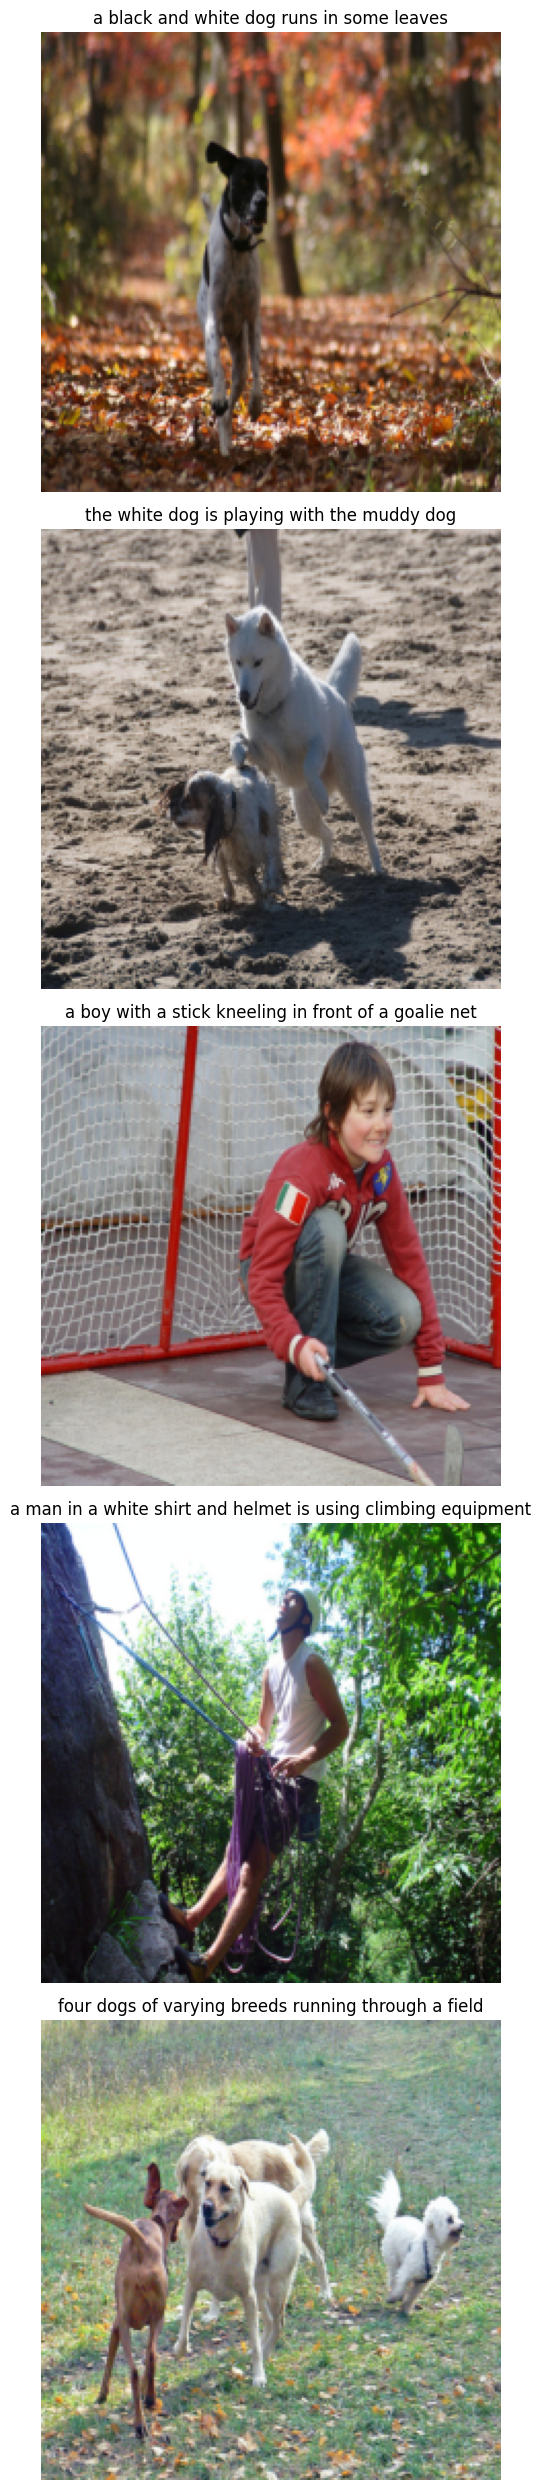

In [53]:
def show_batch(dataloader, idx_to_word):
    for images, captions in dataloader:
        plt.figure(figsize=(15, 25))
        batch_size = images.size(0)

        for i in range(min(5, batch_size)):
            # Convert tensor to image
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            # Decode caption
            cap = captions[i].tolist()
            decoded_cap = []
            for idx in cap:
                word = idx_to_word[idx]
                if word == '<end>':
                    break
                if word not in ['<pad>', '<start>']:
                    decoded_cap.append(word)
            decoded_cap = ' '.join(decoded_cap)

            # Show image and caption
            plt.subplot(5, 1, i+1)
            plt.imshow(img)
            plt.title(decoded_cap)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

show_batch(train_loader, idx_to_word)

In [54]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.6, alpha=0.2, concat=True, num_heads=1):
        super(GATLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat  # If False, do averaging of heads
        self.num_heads = num_heads

        # Create multiple linear transformations and attention vectors for multi-head
        self.W = nn.ModuleList([nn.Linear(in_features, out_features, bias=False) for _ in range(num_heads)])
        self.a1 = nn.ParameterList([nn.Parameter(torch.empty(size=(out_features, 1))) for _ in range(num_heads)])
        self.a2 = nn.ParameterList([nn.Parameter(torch.empty(size=(out_features, 1))) for _ in range(num_heads)])

        for i in range(num_heads):
            nn.init.xavier_uniform_(self.W[i].weight)
            nn.init.xavier_uniform_(self.a1[i])
            nn.init.xavier_uniform_(self.a2[i])

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, x, adj):
        # x: (batch, num_nodes, in_features)
        batch_size, num_nodes, _ = x.size()
        head_outputs = []

        # For each head, compute attention output
        for i in range(self.num_heads):
            Wh = self.W[i](x)  # (batch, num_nodes, out_features)
            attn_self = torch.matmul(Wh, self.a1[i])  # (batch, num_nodes, 1)
            attn_neigh = torch.matmul(Wh, self.a2[i])  # (batch, num_nodes, 1)

            # Compute attention coefficients using broadcasting
            attn_coef = attn_self + attn_neigh.transpose(1, 2)  # (batch, num_nodes, num_nodes)
            attn_coef = self.leakyrelu(attn_coef)

            # Use provided adj matrix as mask (assumed to have self-connections)
            adj_expanded = adj.unsqueeze(0).expand(batch_size, -1, -1)
            mask = (adj_expanded == 0).bool()
            attn_coef = attn_coef.masked_fill(mask, -9e15)

            attn_coef = F.softmax(attn_coef, dim=2)
            attn_coef = F.dropout(attn_coef, self.dropout, training=self.training)

            h_head = torch.bmm(attn_coef, Wh)  # (batch, num_nodes, out_features)
            head_outputs.append(h_head)

        # Concatenate or average heads
        if self.concat:
            h_out = torch.cat(head_outputs, dim=-1)  # (batch, num_nodes, out_features*num_heads)
        else:
            h_out = torch.mean(torch.stack(head_outputs, dim=0), dim=0)  # (batch, num_nodes, out_features)
        # Optionally add residual connection if dimensions match
        if x.size(-1) == h_out.size(-1):
            h_out = h_out + x

        return F.elu(h_out)

# ------------------------------
# Modified Graph Encoder with GAT
# ------------------------------
class GraphEncoder(nn.Module):
    def __init__(self, gat_in_dim=2048, gat_hidden_dim=512, num_gat_layers=2, dropout=0.6, num_heads=4):
        super(GraphEncoder, self).__init__()
        # Use a pretrained ResNet50 and remove the last two layers (avgpool & fc)
        resnet = torchvision.models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        self.num_heads = num_heads

        # Build a stack of GAT layers.
        # To allow multi-head, we set the first layer to output hidden dim divided by number of heads
        self.gat_layers = nn.ModuleList()
        # First layer: note that if concatenated, output dim will be hidden_dim*num_heads
        self.gat_layers.append(GATLayer(gat_in_dim, gat_hidden_dim, dropout=dropout, concat=True, num_heads=num_heads))
        # Additional layers
        for i in range(1, num_gat_layers):
            # For middle layers, if not final, we concatenate heads; final layer we average (concat=False)
            concat = i < num_gat_layers - 1
            self.gat_layers.append(
                GATLayer(gat_hidden_dim * num_heads if i==1 else gat_hidden_dim,
                         gat_hidden_dim, dropout=dropout, concat=concat, num_heads=num_heads)
            )

    def forward(self, images):
        # images: (batch, 3, 224, 224)
        cnn_features = self.cnn(images)  # shape: (batch, 2048, H, W)
        b, c, h, w = cnn_features.size()
        # Flatten spatial dimensions: each spatial location becomes a node.
        features = cnn_features.view(b, c, -1).permute(0, 2, 1)  # (b, num_nodes, 2048)
        num_nodes = features.size(1)

        # For simplicity, we start with a fully-connected graph with self connections.
        # Alternatively, one might compute a kNN graph based on spatial location or feature similarity.
        adj = torch.ones(num_nodes, num_nodes, device=features.device)
        adj = adj.fill_diagonal_(1)

        # Pass through stacked GAT layers.
        for gat in self.gat_layers:
            features = gat(features, adj)
        return features  # (batch, num_nodes, feature_dim)

# ------------------------------
# Decoder with Attention over Graph Nodes
# ------------------------------
class CaptionDecoderWithAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, feature_dim, num_layers=1):
        super(CaptionDecoderWithAttention, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Projection layers for initializing LSTM state from averaged features
        self.init_h = nn.Linear(feature_dim, hidden_size)
        self.init_c = nn.Linear(feature_dim, hidden_size)

        # LSTM for decoding: input is (embed + context)
        self.lstm = nn.LSTM(embed_size + feature_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Attention: project node features and hidden state to a common space
        self.attn_feature = nn.Linear(feature_dim, hidden_size)
        self.attn_hidden = nn.Linear(hidden_size, hidden_size)
        self.attn_score = nn.Linear(hidden_size, 1)

    def forward(self, features, captions):
        # features: (batch, num_nodes, feature_dim)
        batch_size = features.size(0)
        num_nodes = features.size(1)

        # Average features to initialize hidden state and cell state (project to hidden_size)
        features_avg = features.mean(dim=1)  # (batch, feature_dim)
        h0 = self.init_h(features_avg).unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, batch, hidden_size)
        c0 = self.init_c(features_avg).unsqueeze(0).repeat(self.num_layers, 1, 1)  # (num_layers, batch, hidden_size)

        # Get embeddings for all time steps (teacher forcing)
        embeddings = self.embed(captions)  # (batch, seq_len, embed_size)
        seq_len = embeddings.size(1)
        outputs = []
        hidden = (h0, c0)

        for t in range(seq_len):
            emb_t = embeddings[:, t, :]  # (batch, embed_size)

            # Compute attention weights over graph nodes
            h_t = hidden[0][-1]  # (batch, hidden_size)
            proj_features = self.attn_feature(features)      # (batch, num_nodes, hidden_size)
            proj_hidden = self.attn_hidden(h_t).unsqueeze(1)   # (batch, 1, hidden_size)
            attn_weights = self.attn_score(torch.tanh(proj_features + proj_hidden))  # (batch, num_nodes, 1)
            attn_weights = F.softmax(attn_weights, dim=1)       # (batch, num_nodes, 1)
            context = torch.sum(attn_weights * features, dim=1) # (batch, feature_dim)

            # Concatenate embedding with context vector and decode one step
            lstm_input = torch.cat([emb_t, context], dim=1).unsqueeze(1)  # (batch, 1, embed_size + feature_dim)
            out, hidden = self.lstm(lstm_input, hidden)  # out: (batch, 1, hidden_size)
            out = self.fc(out.squeeze(1))  # (batch, vocab_size)
            outputs.append(out)

        outputs = torch.stack(outputs, dim=1)  # (batch, seq_len, vocab_size)
        return outputs

    def generate_caption(self, features, word_to_idx, idx_to_word, max_length=50):
        """Generate caption given node features (batch size = 1)."""
        self.eval()
        with torch.no_grad():
            # Initialize hidden state using the projected average of features
            features_avg = features.mean(dim=1)  # (1, feature_dim)
            h0 = self.init_h(features_avg).unsqueeze(0).repeat(self.num_layers, 1, 1)
            c0 = self.init_c(features_avg).unsqueeze(0).repeat(self.num_layers, 1, 1)
            hidden = (h0, c0)

            input_word = torch.tensor([word_to_idx['<start>']], device=features.device)
            caption_words = []

            for _ in range(max_length):
                emb = self.embed(input_word).unsqueeze(0)  # (1, 1, embed_size)
                h_t = hidden[0][-1]  # (1, hidden_size)
                proj_features = self.attn_feature(features)      # (1, num_nodes, hidden_size)
                proj_hidden = self.attn_hidden(h_t).unsqueeze(1)   # (1, 1, hidden_size)
                attn_weights = self.attn_score(torch.tanh(proj_features + proj_hidden))  # (1, num_nodes, 1)
                attn_weights = F.softmax(attn_weights, dim=1)
                context = torch.sum(attn_weights * features, dim=1) # (1, feature_dim)
                lstm_input = torch.cat([emb.squeeze(1), context], dim=1).unsqueeze(1)  # (1, 1, embed_size+feature_dim)
                out, hidden = self.lstm(lstm_input, hidden)
                out = self.fc(out.squeeze(1))  # (1, vocab_size)
                predicted = out.argmax(dim=1)
                if predicted.item() == word_to_idx['<end>']:
                    break
                caption_words.append(idx_to_word[predicted.item()])
                input_word = predicted
            return ' '.join(caption_words)
# ------------------------------
# Full Graph Captioning Model with GAT and Attention Decoder
# ------------------------------
class GraphCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(GraphCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, word_to_idx, idx_to_word, max_length=50):
        self.eval()
        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0))  # (1, num_nodes, feature_dim)
            caption = self.decoder.generate_caption(features, word_to_idx, idx_to_word, max_length)
            return caption

# ------------------------------
# Training and Validation Routines remain unchanged
# ------------------------------
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, print_every=10):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (images, captions) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            optimizer.zero_grad()

            # Teacher forcing: input captions except the last token; target is caption shifted by one
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

            if (batch_idx + 1) % print_every == 0 or batch_idx == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, captions in val_loader:
                images = images.to(device)
                captions = captions.to(device)
                outputs = model(images, captions[:, :-1])
                loss = criterion(outputs.reshape(-1, outputs.shape[-1]), captions[:, 1:].reshape(-1))
                val_running_loss += loss.item() * images.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_gat_captioning_model.pth')

    return train_losses, val_losses

from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
import torch
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def evaluate_model(model, val_loader, word_to_idx, idx_to_word, device):
    references = []
    hypotheses = []
    model.eval()

    # Use the correct rouge type names expected by the library
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(device)
            for i in range(images.size(0)):
                image = images[i]
                pred_caption = model.generate_caption(image, word_to_idx, idx_to_word)
                hypotheses.append(pred_caption.split())

                ref_caption = captions[i].cpu().numpy().tolist()
                ref_words = [idx_to_word[idx] for idx in ref_caption
                             if idx not in [word_to_idx['<pad>'], word_to_idx['<start>'], word_to_idx['<end>']]]
                references.append([ref_words])

                # Compute ROUGE scores
                ref_text = " ".join(ref_words)
                pred_text = " ".join(pred_caption.split())
                rouge_result = scorer.score(ref_text, pred_text)

                for key in rouge_scores.keys():
                    rouge_scores[key].append(rouge_result[key].fmeasure)

    # BLEU Scores with smoothing
    smooth = SmoothingFunction().method1
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=smooth)
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)

    avg_rouge = {key: sum(rouge_scores[key]) / len(rouge_scores[key]) for key in rouge_scores}

    print(f"BLEU-1: {bleu_1:.4f}")
    print(f"BLEU-2: {bleu_2:.4f}")
    print(f"BLEU-3: {bleu_3:.4f}")
    print(f"BLEU-4: {bleu_4:.4f}")
    print(f"ROUGE scores: {avg_rouge}")

    return {"bleu-1": bleu_1, "bleu-2": bleu_2, "bleu-3": bleu_3, "bleu-4": bleu_4}, avg_rouge


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.0MB/s]


Epoch [1/100], Batch [1/1], Loss: 5.6278
Epoch [1/100], Train Loss: 5.6278, Val Loss: 5.2711
Epoch [2/100], Batch [1/1], Loss: 5.2909
Epoch [2/100], Train Loss: 5.2909, Val Loss: 4.8142
Epoch [3/100], Batch [1/1], Loss: 4.8615
Epoch [3/100], Train Loss: 4.8615, Val Loss: 4.5139
Epoch [4/100], Batch [1/1], Loss: 4.5554
Epoch [4/100], Train Loss: 4.5554, Val Loss: 4.3514
Epoch [5/100], Batch [1/1], Loss: 4.3726
Epoch [5/100], Train Loss: 4.3726, Val Loss: 4.2173
Epoch [6/100], Batch [1/1], Loss: 4.2471
Epoch [6/100], Train Loss: 4.2471, Val Loss: 4.1366
Epoch [7/100], Batch [1/1], Loss: 4.1535
Epoch [7/100], Train Loss: 4.1535, Val Loss: 4.0828
Epoch [8/100], Batch [1/1], Loss: 4.0748
Epoch [8/100], Train Loss: 4.0748, Val Loss: 4.0249
Epoch [9/100], Batch [1/1], Loss: 3.9895
Epoch [9/100], Train Loss: 3.9895, Val Loss: 3.9478
Epoch [10/100], Batch [1/1], Loss: 3.9172
Epoch [10/100], Train Loss: 3.9172, Val Loss: 3.8922
Epoch [11/100], Batch [1/1], Loss: 3.8094
Epoch [11/100], Train Loss

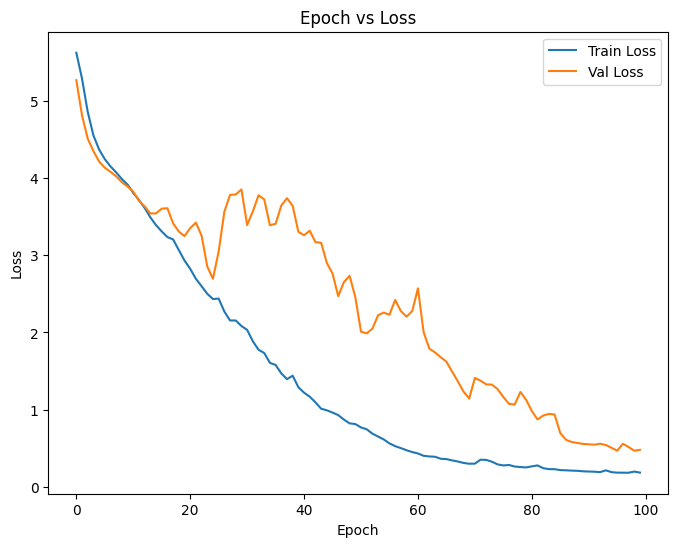

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (adjust as needed)
embed_size = 256
hidden_size = 512
vocab_size = len(word_to_idx)  # Assumes word_to_idx is defined
num_epochs = 100
learning_rate = 1e-3

# Instantiate the encoder and decoder:
# Encoder: Using multi-head GAT with 4 heads. The final output dimension is 256.
encoder = GraphEncoder(gat_in_dim=2048, gat_hidden_dim=256, num_gat_layers=2, dropout=0.6, num_heads=4)
# Decoder: Feature dimension is 256 (from encoder output).
decoder = CaptionDecoderWithAttention(embed_size, hidden_size, vocab_size, feature_dim=256, num_layers=1)
model = GraphCaptioningModel(encoder, decoder).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=word_to_idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

In [27]:
!mkdir -p /content/drive/MyDrive/model_weights
!cp best_gat_captioning_model.pth /content/drive/MyDrive/model_weights

In [28]:
# Load best model for evaluation
model.load_state_dict(torch.load('/content/best_gat_captioning_model.pth', map_location=device))

# Evaluate model: compute BLEU score (and you may add METEOR, ROUGE, etc. as needed)
bleu,rouge = evaluate_model(model, train_loader, word_to_idx, idx_to_word, device)
bleu,rouge

BLEU-1: 0.4151
BLEU-2: 0.3150
BLEU-3: 0.2654
BLEU-4: 0.2278
ROUGE scores: {'rouge1': 0.46793035298617036, 'rouge2': 0.265873167947115, 'rougeL': 0.44948801583038084}


({'bleu-1': 0.41507229231688314,
  'bleu-2': 0.31496572210980234,
  'bleu-3': 0.2654290971692209,
  'bleu-4': 0.2278154988363077},
 {'rouge1': 0.46793035298617036,
  'rouge2': 0.265873167947115,
  'rougeL': 0.44948801583038084})

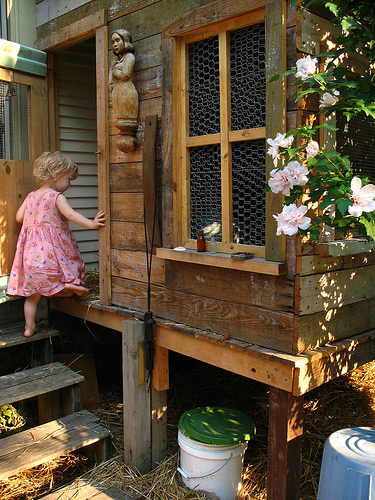

In [29]:
def caption_image(image_path, model, word_to_idx, idx_to_word, transform, device):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.to(device)
    caption = model.generate_caption(image, word_to_idx, idx_to_word)
    return caption


inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_path = os.path.join('/content/Images',captions_df['image'].values[0])
Image.open(img_path)

In [30]:
img_path = os.path.join('/content/Images',captions_df['image'].values[0])
generated_caption = caption_image(img_path, model, word_to_idx, idx_to_word, inference_transform, device)
print("Generated Caption:", generated_caption)

Generated Caption: a little girl in a pink dress going into a wooden cabin
